<a href="https://colab.research.google.com/github/elsandner/ContinuousIntegration/blob/master/hyperparameter_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hyperparameter Tuning**


Preprocessing: 

In [3]:
import tensorflow as tf
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, GRU, Bidirectional
from keras.preprocessing import sequence

!pip install -q -U keras-tuner
import keras_tuner as kt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=20000)  # load imdb data
print("x_train shape: ", x_train.shape, "\ny_train_shape:", y_train.shape)


x_train = sequence.pad_sequences(x_train, 1000)  # transforms a list of sequences into a 2D Numpy array
x_test = sequence.pad_sequences(x_test, 1000)
print(x_train.shape)
len(tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json")) 


#fixes error
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

     |████████████████████████████████| 98 kB 5.4 MB/s 
17473536/17464789 [==============================] - 0s 0us/step
x_train shape:  (25000,) 
y_train_shape: (25000,)
(25000, 1000)
1654784/1641221 [==============================] - 0s 0us/step


**Hyperparameter which we will try to optimize**


*   Unidirectional vs bidirectional GRU layers
*   Number of hidden GRU Layers 
*   Number of hidden units
*   Dropout-rate

What also could be optimized: 
*   activation functions
*   learning rate of optimizer
*   input length (1000 is a best practice value) 
*   more dropout layers between GRU Layers



## Model 1: 
here we test unidirectional GRUs and adopt the number of units and the learning rate of the dropout layer. 

In the unidirectional GRU layer we are testing the unitsizes: 15, 20, 25

In the dropout layer we are testing the dropout-rates: 0.5, 0.6, 0.7, 0.8

**Dropout Rate** (Source: https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) 
The default interpretation of the dropout hyperparameter is the probability of training a given node in a layer, where 1.0 means no dropout, and 0.0 means no outputs from the layer.

A good value for dropout in a hidden layer is between 0.5 and 0.8. Input layers use a larger dropout rate, such as of 0.8.

In [41]:
def build_model_1(hp):
    model = Sequential()

    #  input layer
    model.add(Embedding(input_dim=20000, output_dim=16, input_length=1000))

    #  hidden layers 
    model.add(GRU(units=hp.Int('units1',   
                                 min_value=15,         
                                 max_value=25,
                                 step=5),
                   return_sequences=True   
                   ))

    model.add(Dropout(rate=hp.Float('dropout_rate',
                                    min_value=0.5,
                                    max_value=0.8,
                                    step=0.1)
                      ))

    model.add(Dense(10))

    # output layer
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model


Model 1 is testing hidden units sizes: 15, 20, 25
and dropout-rates: 0.5, 0.6, 0.7, 0.8 
it takes 3*4=12 trials 

In [42]:
tuner_1 = kt.Hyperband(
    build_model_1,
    objective='val_accuracy',
    max_epochs=5,
    factor=3, # 3 is the default value 
    directory='my_dir',
    project_name="DL_project_Tuner_1"
)

tuner_1.search_space_summary()
print("\n")

tuner_1.search(x_train, y_train,
             epochs=5,
             validation_split=0.2
             )
tuner_1.results_summary()
best_model = tuner_1.get_best_models()[0]

Trial 10 Complete [00h 02m 23s]
val_accuracy: 0.5814428925514221

Best val_accuracy So Far: 0.5817626714706421
Total elapsed time: 00h 10m 47s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/DL_project_Tuner_1
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units1: 25
dropout_rate: 0.7999999999999999
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 15cfd9ae353602179d08b9927d0a10d8
Score: 0.5817626714706421
Trial summary
Hyperparameters:
units1: 15
dropout_rate: 0.7
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5816506147384644
Trial summary
Hyperparameters:
units1: 25
dropout_rate: 0.7999999999999999
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5815693736076355
Trial summary
Hyperparameters:
units1: 20
dropout_rate: 0.7
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.58144

---

**TEST ONE ENDS HERE!!**

Total elapsed time: 00h 24m 29s

**Best Result Hyperparameters:** 

units1: 15

dropout_rate: 0.5

Score: 0.5700136423110962

---

Now we will execute the same test but use a bidirectional GRU layer

In [43]:
def build_model_2(hp):
    model = Sequential()

    #  input layer
    model.add(Embedding(input_dim=20000, output_dim=16, input_length=1000))

    #  hidden layers 
    model.add(Bidirectional(GRU(units=hp.Int('units1',   
                                 min_value=15,         
                                 max_value=25,
                                 step=5),
                   return_sequences=True   
                   )))

    model.add(Dropout(rate=hp.Float('dropout_rate',
                                    min_value=0.5,
                                    max_value=0.8,
                                    step=0.1)
                      ))

    model.add(Dense(10))

    # output layer
    model.add(Dense(1, activation='sigmoid')) 

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [44]:
tuner_2 = kt.Hyperband(
    build_model_2,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name="DL_project_NumOfUnits"
)

tuner_2.search_space_summary()

tuner_2.search(x_train, y_train,
             epochs=5,
             validation_split=0.2
             )
tuner_2.results_summary()
best_model = tuner_2.get_best_models()[0]

Trial 10 Complete [00h 02m 49s]
val_accuracy: 0.8716862201690674

Best val_accuracy So Far: 0.8716862201690674
Total elapsed time: 00h 19m 10s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/DL_project_NumOfUnits
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units1: 15
dropout_rate: 0.5
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8716862201690674
Trial summary
Hyperparameters:
units1: 20
dropout_rate: 0.5
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8708405494689941
Trial summary
Hyperparameters:
units1: 20
dropout_rate: 0.7
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: c3b023bdf197d6e0107074017df3eb62
Score: 0.8560376167297363
Trial summary
Hyperparameters:
units1: 20
dropout_rate: 0.7
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8556506633758545
Trial summary
H

---

***Model 2 Test is done here!!***

Total elapsed time: 00h 43m 33s

Best Result Hyperparameters:

units1: 20

dropout_rate: 0.5

Score: 0.8619143962860107
---


In [45]:
def build_model_3(hp):
    model = Sequential()

    #  input layer
    model.add(Embedding(input_dim=20000, output_dim=16, input_length=1000))

    #  hidden layers 
    for i in range(hp.Int('layers', 1, 5)):             # using 1-5 GRU layers
        model.add(Bidirectional(GRU(20, return_sequences=True))) 

    model.add(Dropout(0.5))
    model.add(Dense(10))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model


In [46]:
tuner_3 = kt.Hyperband(
    build_model_3,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name="DL_project_NumOfLayers"
)

tuner_3.search_space_summary()

tuner_3.search(x_train, y_train,
             epochs=5,
             validation_split=0.2
             )
tuner_3.results_summary()
best_model = tuner_3.get_best_models()[0]

Trial 7 Complete [00h 03m 14s]
val_accuracy: 0.8962533473968506

Best val_accuracy So Far: 0.8966641426086426
Total elapsed time: 00h 26m 22s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/DL_project_NumOfLayers
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 4
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 2e10713edf43c69cc0b33340f54a1fff
Score: 0.8966641426086426
Trial summary
Hyperparameters:
layers: 2
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 1866371aacd4398808598b5376bfb0f2
Score: 0.8962533473968506
Trial summary
Hyperparameters:
layers: 4
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8911047577857971
Trial summary
Hyperparameters:
layers: 2
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8880936503410339
Trial summary
Hyperparameters:
layers: 3
t

---

***Model 3 Test is done here!!***

Total elapsed time: 00h 55m 38s

Best Result Hyperparameters:

layers: 2

Score: 0.8920307159423828
---


In [1]:
def build_model_4(hp):
    model = Sequential()

    #  input layer
    model.add(Embedding(input_dim=20000, output_dim=16, input_length=1000))

    #  hidden layers 
    model.add(Bidirectional(GRU(20, return_sequences=True)))  
    model.add(Bidirectional(GRU(20, return_sequences=True)))  
    model.add(Dropout(0.5))
    model.add(Dense(10))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(
        #optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-1, 1e-2,1e-3, 1e-4])),

        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model


In [4]:
tuner_4 = kt.Hyperband(
    build_model_4,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name="DL_project_optimizer"
)

tuner_4.search_space_summary()

tuner_4.search(x_train, y_train,
             epochs=5,
             validation_split=0.2
             )
tuner_4.results_summary()
best_model = tuner_4.get_best_models()[0]

Trial 4 Complete [00h 03m 26s]
val_accuracy: 0.891549289226532

Best val_accuracy So Far: 0.9090842604637146
Total elapsed time: 00h 13m 26s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/DL_project_optimizer
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9090842604637146
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.891549289226532
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.832009494304657
Trial summary
Hyperparameters:
learning_rate: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5062000155448914


---

***Model 4 Test is done here!!***

Total elapsed time: 00h 09m 39s

Best Result Hyperparameters:

Learning Rate: 0.01

Score: 0.9075791239738464
---

So the best model is: 
layers: 2
units: 20
learning rate: 0.01
dropout rate: 0.5



Plot function from Thomas

In [5]:

model = Sequential()

#  input layer
model.add(Embedding(input_dim=20000, output_dim=16, input_length=1000))

#  hidden layers 
model.add(Bidirectional(GRU(20, return_sequences=True)))  
model.add(Bidirectional(GRU(20, return_sequences=True)))  
model.add(Dropout(0.5))
model.add(Dense(10))

# output layer
model.add(Dense(1, activation='sigmoid'))  

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='binary_crossentropy',
    metrics=['accuracy'])


In [6]:
# earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'loss',verbose = 0, mode = 'auto', patience = 3)
# history = model.fit(x_train, y_train, epochs=20, batch_size=32, callbacks=[earlystop]) 

history = model.fit(x_train, y_train, epochs=20, batch_size=32, callbacks=[earlystop]) 
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
782/782 [==============================] - 104s 127ms/step - loss: 0.3716 - accuracy: 0.8088
Epoch 2/20
782/782 [==============================] - 99s 127ms/step - loss: 0.1455 - accuracy: 0.9500
Epoch 3/20
782/782 [==============================] - 99s 127ms/step - loss: 0.0672 - accuracy: 0.9787
Epoch 4/20
782/782 [==============================] - 99s 127ms/step - loss: 0.0382 - accuracy: 0.9880
Epoch 5/20
782/782 [==============================] - 99s 126ms/step - loss: 0.0287 - accuracy: 0.9913
Epoch 6/20
782/782 [==============================] - 99s 127ms/step - loss: 0.0205 - accuracy: 0.9937
Epoch 7/20
782/782 [==============================] - 99s 126ms/step - loss: 0.0496 - accuracy: 0.9835
Epoch 8/20
782/782 [==============================] - 99s 126ms/step - loss: 0.1114 - accuracy: 0.9624
Epoch 9/20
782/782 [==============================] - 99s 126ms/step - loss: 0.0565 - accuracy: 0.9818
Epoch 10/20
782/782 [==============================] - 99s 126ms/step - 

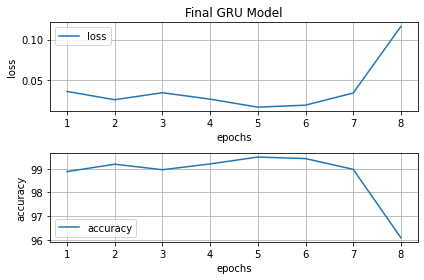

In [37]:
from matplotlib import pyplot as plt
def plotMetrics(model, title, SAFE_PLOTS=False, directory="", filename=""):

    counter = 0
    fig, ax = plt.subplots(2,1)
    #for label,values in model.history.history.items():
    for label,values in history.history.items():
      # counter 0,2 -> loss
      # counter 1,3 -> accuracy
      # depending on counter plot loss or accuracy
      # accuracy is calculated in % -> times 100

      values_ = (counter%2)*100*np.array(values) + (1-(counter%2))*np.array(values)
      ax[counter % 2].plot(range(1,len(values)+1,1), values_ , label=label)
      
      counter = counter + 1
    
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].grid()
    ax[1].legend()

    ax[0].set_title(title)

    fig.tight_layout()
    
    
    if SAFE_PLOTS:
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory+filename)
    
    plt.show()


plotMetrics(history, "Final GRU Model")

When using the final model, we can reach a **value accuracy of 99.67%** when using 9 Epochs!